In [1]:
from primitives.primitives import *
from cirq import Circuit, LineQid, measure, sample, Simulator
from scipy.linalg import expm
import matplotlib.pyplot as plt
from numpy.linalg import eig
import re
from scipy import sparse


simulator = Simulator()

## t-V model definition

One-dimensional spinless t-V model (range=1):

$H = -t \sum_{i=1}^{L} \left( c_i^\dagger c_{i+1} + h.c.\right) + V \sum_{i=1}^L n_i n_{i+1}$

In the 2D case we have to define horizontal and vertical hopping operators.

### Horizontal hopping operators

$H_x^{hop} (i, i+1) = i \Gamma^1_{i} \Gamma^2_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [2]:
x_hop_matrix = 1j * TensorProduct(sy_gamma_1 * sy_gamma_5, sy_gamma_2) - 1j * TensorProduct(sy_gamma_1, sy_gamma_2 * sy_gamma_5)
class HopXGate(Gate):
    """Horizontal hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(x_hop_matrix)
    def _circuit_diagram_info_(self, args):
        return ["H_x(r)", "H_x(r+1)"]
x_hop_matrix

Matrix([
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0, -2.0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0, 2.0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0, 2.0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0, -2.0,   0, 0],
[0,    0, 2.0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0, -2.0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0,    0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,   0, 0,   0, 0, 0, -2.0,   0, 0, 0,    0, 0,    0,   0, 0],
[0,    0,  

### Vertical hopping operators

$H_y^{hop} (i, i+1) = i \Gamma^3_{i} \Gamma^4_{i+1} \left(\tilde \Gamma_i -\tilde\Gamma_{i+1}\right)$

In [3]:
y_hop_matrix = 1j * TensorProduct(sy_gamma_3 * sy_gamma_5, sy_gamma_4) - 1j * TensorProduct(sy_gamma_3, sy_gamma_4 * sy_gamma_5)
class HopYGate(Gate):
    """Vertical hopping gate."""
    def _qid_shape_(self):
        return (4, 4)
    def _unitary_(self):
        return np.array(y_hop_matrix)
    def _circuit_diagram_info_(self, args):
        return ["H_y(r)", "H_y(r+1)"]
y_hop_matrix

Matrix([
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0, 2.0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0, 2.0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0, 2.0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0, 2.0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0, -2.0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0, -2.0, 0],
[0,   0,   0, 0,   0, 0, 0,   0,    0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   0, 0,   0, 0, 0,   0, -2.0, 0, 0,    0, 0,    0,    0, 0],
[0,   0,   

### Number operator

$n_i = \frac{1}{2} - \frac{1}{2}\tilde \Gamma_i$

In [19]:
number_matrix = 0.5 * (sy_id - sy_gamma_5)
class NumberGate(Gate):
    """Number gate."""
    def _qid_shape_(self):
        return (4,)
    def _unitary_(self):
        return np.array(number_matrix)
    def _circuit_diagram_info_(self, args):
        return ["n(r)"]
number_matrix

Matrix([
[0,   0,   0, 0],
[0, 1.0,   0, 0],
[0,   0, 1.0, 0],
[0,   0,   0, 0]])

In [5]:
double_number_matrix = TensorProduct(number_matrix, number_matrix)
class DoubleNumberGate(Gate):
    """Double number gate."""
    def _qid_shape_(self):
        return (4,4)
    def _unitary_(self):
        return np.array(double_number_matrix)
    def _circuit_diagram_info_(self, args):
        return ["n(r)", "n(r+1)"]
double_number_matrix

Matrix([
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0, 1.0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0, 1.0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0, 1.0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0, 1.0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0],
[0, 0, 0, 0, 0,   0,   0, 0, 0,   0,   0, 0, 0, 0, 0, 0]])

### Evolution gates

In [6]:
def evolve_gate(gate):
    class evolved(Gate):
        def __init__(self, C=1, t=0.1):
            self.C = C  # coefficient
            self.t = t  # evolution time
            self.matrix = expm(np.array(-1j * self.t * self.C * gate()._unitary_(), dtype=np.complex128))
            super()
        def _qid_shape_(self):
            return gate()._qid_shape_()
        def _circuit_diagram_info_(self, args):
            return gate()._circuit_diagram_info_(args)
        def _unitary_(self):
            return self.matrix
    return evolved

# example:
evolution_hopping = evolve_gate(HopYGate)(C = 1, t = 0.5)

## Evolving a state

In [15]:
def evolve(qudits, temps, initial=None, T=1, V=0, exact=False, shots=10):

    if initial is None:
        initial = []

    if len(temps) > 1:
        if V != 0:
            evolution_number = evolve_gate(DoubleNumberGate)(t = temps[1]-temps[0])
        evolution_horizontal_hop = evolve_gate(HopXGate)(C=T, t = temps[1]-temps[0])
        evolution_vertical_hop = evolve_gate(HopYGate)(C=T, t = temps[1]-temps[0])

    results = []
    evolution_circuit = []
    for idx, t in enumerate(temps):

        if t != 0:    
            rows, cols = qudits.shape
            for row in range(rows):
                for col in range(cols):

                    # WITHOUT PERIODIC BOUNDS

                    # vertical interaction
                    if row != rows - 1:
                        a = qudits[row][col]
                        b = qudits[row+1][col]
                        if V != 0:
                            evolution_circuit.append(evolution_number(a, b))
                        evolution_circuit.append(evolution_vertical_hop(a, b))
                    # horizontal interaction
                    if col != cols - 1:
                        a = qudits[row][col]
                        b = qudits[row][col+1]
                        if V != 0:
                            evolution_circuit.append(evolution_number(a, b))
                        evolution_circuit.append(evolution_vertical_hop(a, b))
                    
        if not exact:
            measures = [measure(qudit, key=f"q{idx}") for idx, qudit in enumerate(qudits.flatten())]
            circuit = Circuit([*initial, *evolution_circuit, *measures])
            results.append((circuit, sample(circuit, repetitions=shots)))
        else:
            circuit = Circuit([*initial, *evolution_circuit])
            results.append((circuit, simulator.simulate(circuit)))
            
    return results

## Constraints

The constraint is (for every plaquette):
$\Gamma^{23}_{r}\Gamma^{23}_{r+x}\Gamma^{23}_{r+x+y}\Gamma^{23}_{r+y} \tilde\Gamma_r \tilde\Gamma_{r+x+y}= I$

We call the first operator G

In [12]:
G = np.array(TensorProduct(sy_gamma_1*sy_gamma_3, sy_gamma_2*sy_gamma_3, sy_gamma_4*sy_gamma_2, sy_gamma_1*sy_gamma_4))

class Project_Constraint_minus(Gate):
    """Gate that prepare an initial state, from the coefficients."""

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return (np.eye(4**4) - G)/2

    def _circuit_diagram_info_(self, args):
        return ["P-", "P-", "P-", "P-"]

class Project_Constraint(Gate):
    """Gate that prepare an initial state, from the coefficients."""

    def _qid_shape_(self):
        return (4, 4, 4, 4)

    def _unitary_(self):
        return (np.eye(4**4) + G)/2

    def _circuit_diagram_info_(self, args):
        return ["P+", "P+", "P+", "P+"]
Project_Constraint()._unitary_()

array([[0.500000000000000, 0, 0, ..., 0, 0, -0.500000000000000],
       [0, 0.500000000000000, 0, ..., 0, 0.500000000000000, 0],
       [0, 0, 0.500000000000000, ..., 0.500000000000000, 0, 0],
       ...,
       [0, 0, 0.500000000000000, ..., 0.500000000000000, 0, 0],
       [0, 0.500000000000000, 0, ..., 0, 0.500000000000000, 0],
       [-0.500000000000000, 0, 0, ..., 0, 0, 0.500000000000000]],
      dtype=object)

### Add fermions

The creation operator for pairs of fermions is:

$f^\dagger_r f^\dagger_{r+x}=i \Gamma^1_r \Gamma^2_{r+x} \frac{(I + \tilde\Gamma_r)(I + \tilde \Gamma_{r+x})}{4}$

In [13]:
class AddPair(Gate):
    """Add pair of fermions (r)+(r+x)."""
    
    def _qid_shape_(self):
        return (4, 4)

    def _unitary_(self):
        return np.array(1j * (1/4) * TensorProduct(sy_gamma_1, sy_gamma_2) * TensorProduct(sy_id + sy_gamma_5, sy_id + sy_gamma_5))

    def _circuit_diagram_info_(self, args):
        return ["f+", "f+"]

AddPair()._unitary_()

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1.00000000000000],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -1.00000000000000, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [-1.00000000000000, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=object)

## Evolving a 4x2 lattice

In [72]:
rows = 2
columns = 4

T = -1
V = 0.01

qudits = np.array(LineQid.range(rows * columns, dimension=4)).reshape(rows, columns)
temps = np.arange(0, 11, 5)

# initial circuit that ensures that the correct subspace is used (really?)
initial_circuit = [
    #GateId()(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0]),
    Project_Constraint()(qudits[0][0], qudits[0][1], qudits[1][1], qudits[1][0]),
    Project_Constraint()(qudits[0][1], qudits[0][2], qudits[1][2], qudits[1][1]),
    Project_Constraint()(qudits[0][2], qudits[0][3], qudits[1][3], qudits[1][2]),
    
    #Project_Constraint()(qudits[1][0], qudits[1][1], qudits[0][1], qudits[0][0]),
    #Project_Constraint()(qudits[1][1], qudits[1][2], qudits[0][2], qudits[0][1]),
    #Project_Constraint()(qudits[1][2], qudits[1][3], qudits[0][3], qudits[0][2]),
    #Project_Constraint()(qudits[0][3], qudits[0][0], qudits[0][1], qudits[1][3]),

    #AddPair()(qudits[0][0], qudits[0][1]),
    #AddPair()(qudits[0][2], qudits[0][3]),
    AddPair()(qudits[1][0], qudits[1][1]),
    AddPair()(qudits[1][2], qudits[1][3]),

]

# results is a list of tuples, every tuple contains the circuit and the result shots
exact = True
results = evolve(qudits, temps, initial_circuit, T=T, V=V, exact=exact)

In [73]:
results[1][0]

┌────┐
0 (d=4): ───P+─────────────────n(r)─────H_y(r)─────n(r)─────H_y(r)─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
            │                  │        │          │        │
1 (d=4): ───P+───P+────────────┼────────┼──────────n(r+1)───H_y(r+1)───n(r)─────H_y(r)─────n(r)─────H_y(r)─────────────────────────────────────────────────────────────────────────────────────
            │    │             │        │                              │        │          │        │
2 (d=4): ───┼────P+────P+──────┼────────┼──────────────────────────────┼────────┼──────────n(r+1)───H_y(r+1)───n(r)─────H_y(r)─────n(r)─────H_y(r)─────────────────────────────────────────────
            │    │     │       │        │                              │        │                              │        │          │        │
3 (d=4): ───┼────┼─────P+──────┼────────┼──────────────────────────────┼────────┼──────────────────────────────┼────────┼──────────n(r+1)───H_y(r+1)───n(r)─────H_y(r)─────────────────────────
            │    │     │       │        │                              │        │                              │        │                              │        │
4 (d=4): ───P+───┼─────┼─f+────n(r+1)───H_y(r+1)───────────────────────┼────────┼──────────n(r)─────H_y(r)─────┼────────┼──────────────────────────────┼────────┼──────────────────────────────
            │    │     │ │                                             │        │          │        │          │        │                              │        │
5 (d=4): ───P+───P+────┼─f+────────────────────────────────────────────n(r+1)───H_y(r+1)───n(r+1)───H_y(r+1)───┼────────┼──────────n(r)─────H_y(r)─────┼────────┼──────────────────────────────
                 │     │                                                                                       │        │          │        │          │        │
6 (d=4): ────────P+────P+──────f+──────────────────────────────────────────────────────────────────────────────n(r+1)───H_y(r+1)───n(r+1)───H_y(r+1)───┼────────┼──────────n(r)─────H_y(r)─────
                       │       │                                                                                                                       │        │          │        │
7 (d=4): ──────────────P+──────f+──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────n(r+1)───H_y(r+1)───n(r+1)───H_y(r+1)───
                      └────┘

In [74]:
test = results[0][1]
test

measurements: (no measurements)

qubits: (cirq.LineQid(0, dimension=4), cirq.LineQid(1, dimension=4), cirq.LineQid(5, dimension=4), cirq.LineQid(4, dimension=4), cirq.LineQid(2, dimension=4), cirq.LineQid(6, dimension=4), cirq.LineQid(3, dimension=4), cirq.LineQid(7, dimension=4))
output vector: 0.125|00220202⟩ + 0.125|00223131⟩ - 0.125|03120231⟩ + 0.125|03123102⟩ + 0.125|30210231⟩ - 0.125|30213102⟩ + 0.125|33110202⟩ + 0.125|33113131⟩

phase:
output vector: |⟩

In [75]:
def expectation_value(result, qudits, operator):
    rho = test.density_matrix_of(qudits)
    
    srho = sparse.csr_matrix(np.array(rho, dtype=np.complex128)) 
    srho /= srho.trace()
    shop = sparse.csr_matrix(np.array(operator, dtype=np.complex128))
    val = srho * shop

    tr = val.trace()
    if np.imag(tr) != 0:
        print(f"Casting {tr} to real")
    return np.real(tr)

expectation_value(results[0][1], [qudits[0][0]], number_matrix)

0.0

## Operators evolution

In [76]:
line_styles = ['-.', '--', '-.', ':', '-.', '--', '-.', ':']
markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p']

### Constraints

(-1.1, 1.1)

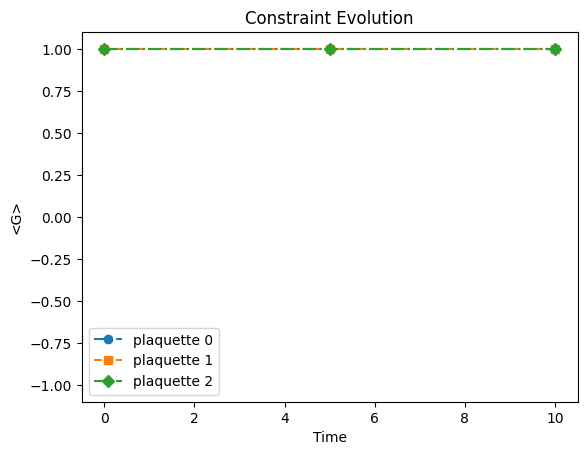

In [77]:
plaqs = [
    [qudits[0][0], qudits[0][1], qudits[1][0], qudits[1][1]],
    [qudits[0][1], qudits[0][2], qudits[1][1], qudits[1][2]],
    [qudits[0][2], qudits[0][3], qudits[1][2], qudits[1][3]]
]
# operator G (order different from before...)
operator = np.array(TensorProduct(sy_gamma_1*sy_gamma_3, sy_gamma_2*sy_gamma_3, sy_gamma_1*sy_gamma_4, sy_gamma_4*sy_gamma_2))

evol_res = {"0": [], "1": [], "2": []}

for idx, plaquette in enumerate(plaqs):
    for state in results:
        #operator = G
        val = expectation_value(state[1], plaquette, operator)
        evol_res[str(idx)].append(np.abs(val))

for i in range(3):
    plt.plot(temps, evol_res[str(i)], label=f"plaquette {i}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Constraint Evolution")
plt.xlabel("Time")
plt.ylabel("<G>")
plt.legend()
plt.ylim(-1.1, 1.1)

### Numbers

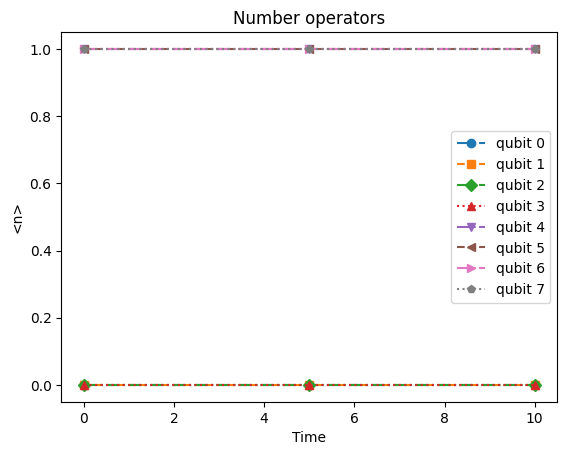

In [78]:
subsystems = [
    [0], [1], [2], [3], [4], [5], [6], [7]
]
num_evol_res = {str(i[0]): [] for i in subsystems}

for idx, sys in enumerate(subsystems):
    for state in results:
        operator = number_matrix
        val = expectation_value(state, [qudits.flatten()[idx]], operator)
        num_evol_res[str(idx)].append(np.abs(val))
        
for i, key in enumerate(num_evol_res):
    plt.plot(temps, num_evol_res[key], label=f"qubit {key}", linestyle=line_styles[i], marker=markers[i])
    
plt.title("Number operators")
plt.xlabel("Time")
plt.ylabel("<n>")
plt.legend()

### Hamiltonian

Text(0, 0.5, '<E>')

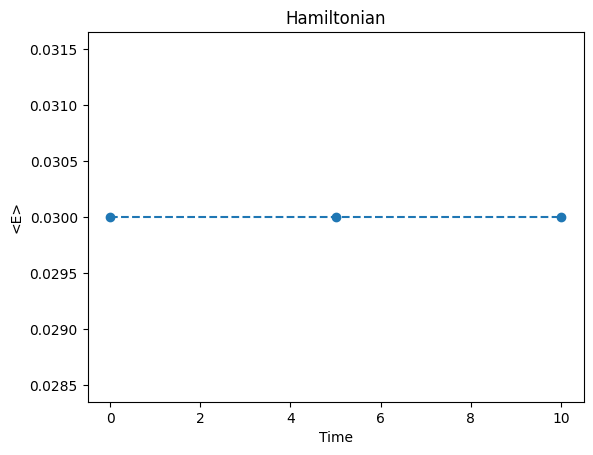

In [79]:
x_hop_couples = []
y_hop_couples = []

rows, cols = qudits.shape
for row in range(rows):
    for col in range(cols):
        if row != rows - 1:
            y_hop_couples.append([qudits[row][col], qudits[row+1][col]])
        if col != cols - 1:
            x_hop_couples.append([qudits[row][col], qudits[row][col+1]])


hamiltonian_results = []

for state in results:
    ham = 0

    # number term
    couples = x_hop_couples + y_hop_couples
    for couple in couples:
        n = 0.5 * (sy_id - sy_gamma_5)
        operator = V * double_number_matrix
        val = expectation_value(state, couple, operator)
        ham += val

    # x_hop term
    for couple in x_hop_couples:
        operator = T * x_hop_matrix
        val = expectation_value(state, couple, operator)
        ham += val    
        
    # y_hop term
    for couple in y_hop_couples:
        operator = T * y_hop_matrix
        val = expectation_value(state, couple, operator)
        ham += val

    hamiltonian_results.append(ham)

plt.plot(temps, hamiltonian_results, "o--",)
    
plt.title("Hamiltonian")
plt.xlabel("Time")
plt.ylabel("<E>")